## **Using TextBlob to Perform Sentimental Analysis**

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)


!pip install python-Levenshtein
from Levenshtein import distance as lev

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import difflib
from IPython import display

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


     |████████████████████████████████| 50 kB 2.4 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149859 sha256=a40d16fbe4154fe6b4140c6e81df6fb5178cb61b92a40fa24a6e58052f5e0de9
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
pip install NRCLex

     |████████████████████████████████| 396 kB 5.3 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=92d1d075e7e77b66b3d2ae7f79f3ceea0d1e33ded5b445bb2b78a97ac9300386
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [ ]:
from nrclex import NRCLex

## File Loading

Loading the csv file and creating a list of unique urls, sorted by crawl_date count.

In [ ]:
web_page_text = pd.read_csv("https://raw.githubusercontent.com/BrockDSL/ARCH_Data_Explore/main/snap_shot_canada_ca.csv")
#web_page_text = pd.read_csv("https://raw.githubusercontent.com/BrockDSL/ARCH_Data_Explore/main/snap_shot_canada_ca.csv")

web_page_text['crawl_date']= pd.to_datetime(web_page_text['crawl_date'],format='%Y%m%d')
web_page_text = web_page_text.sort_values(by=['url', 'crawl_date'], ascending=[True, False])
web_page_text.sample(1)

crawl_date     domain  \
229 2020-07-24  canada.ca   

                                                                                                                                                        url  \
229  https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/prevention-risks/about-non-medical-masks-face-coverings.html   

    mime_type_web_server mime_type_tika language  \
229  text/html            text/html      en        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [ ]:
url_count_list = pd.DataFrame(web_page_text.groupby(["url"]).count().sort_values(by="crawl_date",ascending=False)).index.to_list()
url_count_list[0]


'https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html'

##Tokenize and Remove Stopwords
Removing any words that do not add to the content such as "a", "can", "be"

In [ ]:
stop_words = set(stopwords.words("english"))

def filter_content(row):
  word_tokens = word_tokenize(row['content'])

  filtered_list = [w for w in word_tokens if not w.lower() in stop_words]
  filtered_sentence = " ".join(filtered_list)

  return filtered_sentence


web_page_text['filtered_content'] = web_page_text.apply(filter_content, axis=1)
web_page_text.sample(1)

crawl_date     domain  \
325 2020-08-14  canada.ca   

                                                                                                                                                                            url  \
325  https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html?utm_campaign=not-applicable&utm_medium=vanity-url&utm_source=canada-ca_covid-19   

    mime_type_web_server mime_type_tika language  \
325  text/html            text/html      en        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

##Most Common Words
The top 20 most common words across all articles after removing all stopwords and punctuations.

In [ ]:
from collections import Counter
import regex as re

most_common_words = web_page_text
most_common_words['filtered_content'] = most_common_words['filtered_content'].str.replace('[^\w\s]','')

most_common_words['words'] = most_common_words['filtered_content'].apply(lambda x:str(x.lower()).split())
top = Counter([item for sublist in most_common_words['words'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['common_words','count']
temp.style.background_gradient(cmap='Blues')

,common_words,count
0,canada,55961
1,covid19,38354
2,support,35687
3,health,18563
4,go,16982
5,question,16031
6,previous,15803
7,learn,14280
8,program,13295
9,government,12932


## Calculating the Polarity and Subjectivity for all Article Content

Here we are applying TextBlob to find the sentiment of the article's content. <br>
* The polarity can range from -1.0 to 1.0 (negative to positive)
<br>
* The subjectivity can range from 0.0 to 1.0 (objective to subjective)

In [ ]:
#creating a function to obtain the polarity and subjectivity from the content column, using TextBlob
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity


web_page_text['polarity'] = web_page_text['content'].apply(getPolarity)
web_page_text['subjectivity'] = web_page_text['content'].apply(getSubjectivity)

web_page_text['filtered_polarity'] = web_page_text['filtered_content'].apply(getPolarity)
web_page_text['filtered_subjectivity'] = web_page_text['filtered_content'].apply(getSubjectivity)
web_page_text.sample(1)

,crawl_date,domain,url,mime_type_web_server,mime_type_tika,language,content,filtered_content,words,polarity,subjectivity,filtered_polarity,filtered_subjectivity
41,2020-05-16,canada.ca,https://www.canada.ca/en/revenue-agency/services/benefits/emergency-student-benefit.html?utm_source=Structureddata&utm_medium=FAQPage&utm_campaign=COVID-19,text/html,text/html,en,"Canada Emergency Student Benefit (CESB) - Canada.ca Skip to main content Skip to ""About this site"" Language selection Français Government of Canada Search Search Canada.ca Search Menu Main Menu Jobs and the workplace Immigration and citizenship Travel and tourism Business and industry Benefits Health Taxes Environment and natural resources National security and defence Culture, history and sport Policing, justice and emergencies Transport and infrastructure Canada and the world Money and finances Science and innovation You are here: Canada.ca Benefits COVID-19 - Emergency benefits Canada Emergency Student Benefit (CESB) The Canada Emergency Student Benefit (CESB) provides financial support to post-secondary students, and recent post-secondary and high school graduates who are unable to find work due to COVID-19. This benefit is for students who do not qualify for the Canada Emergency Response Benefit (CERB) or Employment Insurance (EI). From May to August 2020, the CESB provides a payment to eligible students of: $1,250 For each 4-week period or $2,000 For each 4-week period, if you have dependants or a disability To look for a job: Visit Job Bank By using the Job Bank, you can keep track of your job search activities in one place. Sections Who can apply: Canada Emergency Student Benefit (CESB) Who is eligible for the CESB How much you can get: Canada Emergency Student Benefit (CESB) Payment amounts and dates for CESB eligibility periods Which periods you can apply for: Canada Emergency Student Benefit (CESB) Determine how many CESB eligibility periods you can apply for How to apply: Canada Emergency Student Benefit (CESB) When and how to apply for the CESB Keep getting your payments: Canada Emergency Student Benefit (CESB) Looking for work during COVID-19 and when to re-apply for the CESB Return or repay a payment: Canada Emergency Student Benefit (CESB) When and how to return or repay CESB Contact us about CESB: Canada Emergency Student Benefit (CESB) How to contact the CRA with questions about CESB Report a problem or mistake on this page Please select all that apply: A link, button or video is not working It has a spelling mistake Information is missing Information is outdated or wrong Login error when trying to access an account (e.g. My Service Canada Account) GC Key access SecureKey Concierge (Banking Credential) access Personal Access Code (PAC) problems or EI Access Code (AC) problems Social Insurance Number (SIN) validation problems Other login error not in this list I can't find what I'm looking for Other issue not in this list Submit Thank you for your help! You will not receive a reply. For enquiries, contact us. Date modified: 2020-05-13 About government Contact us Departments and agencies Public service and military News Treaties, laws and regulations Government-wide reporting Prime Minister How government works Open government About this site Social media Mobile applications About Canada.ca Terms and conditions Privacy Top of page",Canada Emergency Student Benefit CESB Canadaca Skip main content Skip site Language selection Français Government Canada Search Search Canadaca Search Menu Main Menu Jobs workplace Immigration citizenship Travel tourism Business industry Benefits Health Taxes Environment natural resources National security defence Culture history sport Policing justice emergencies Transport infrastructure Canada world Money finances Science innovation Canadaca Benefits COVID19 Emergency benefits Canada Emergency Student Benefit CESB Canada Emergency Student Benefit CESB provides financial support postsecondary students recent postsecondary 

In [ ]:
#assigning an adjective to the sentiment calcuations, for the purpose of grouping and not having to manage the different floats
def assignPolarity(polarity):
  if polarity > 0:
    return "Positive"
  elif polarity == 0:
    return "Neutral"
  else:
    return "Negative"

def assignSubjectivity(subjectivity):
  if subjectivity > 0.5:
    return "Subjective"
  elif subjectivity == 0.5:
    return "Neutral"
  else:
    return "Objective"


web_page_text['polarity_type'] = web_page_text['polarity'].apply(assignPolarity)
web_page_text['subjectivity_type'] = web_page_text['subjectivity'].apply(assignSubjectivity)

web_page_text['filtered_polarity_type'] = web_page_text['filtered_polarity'].apply(assignPolarity)
web_page_text['filtered_subjectivity_type'] = web_page_text['filtered_subjectivity'].apply(assignSubjectivity)

web_page_sentiment = web_page_text[['crawl_date', 'domain', 'url', 'polarity', 'polarity_type', 'filtered_polarity', 'filtered_polarity_type', 
                                    'subjectivity', 'subjectivity_type', 'filtered_subjectivity', 'filtered_subjectivity_type']]
web_page_sentiment.sample(5)

,crawl_date,domain,url,polarity,polarity_type,filtered_polarity,filtered_polarity_type,subjectivity,subjectivity_type,filtered_subjectivity,filtered_subjectivity_type
1119,2021-05-28,canada.ca,https://www.canada.ca/en/department-finance/news/2020/03/canadas-covid-19-economic-response-plan-support-for-canadians-and-businesses.html,0.078868,Positive,0.082022,Positive,0.402029,Objective,0.392680,Objective
850,2021-02-26,canada.ca,https://www.canada.ca/en/department-finance/news/2021/02/department-of-finance-releases-draft-legislation-to-increase-accessibility-of-canada-emergency-wage-subsidy-and-canada-emergency-rent-subsidy.html,0.118750,Positive,0.090000,Positive,0.384146,Objective,0.371429,Objective
937,2021-03-26,canada.ca,https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/symptoms.html,0.053623,Positive,-0.001153,Negative,0.359461,Objective,0.332061,Objective
377,2020-09-04,canada.ca,https://www.canada.ca/en.html,0.038802,Positive,0.023148,Positive,0.331667,Objective,0.319907,Objective
1101,2021-05-21,canada.ca,https://www.canada.ca/en/health-canada/services/drugs-health-products/covid19-industry/drugs-vaccines-treatments/vaccines.html,0.052778,Positive,0.005000,Positive,0.512037,Subjective,0.522778,Subjective


In [ ]:
def checkPolarities(row):
  if row['polarity_type'] == row['filtered_polarity_type']:
    return True
  else:
    return False

def checkSubjectivities(row):
  if row['subjectivity_type'] == row['filtered_subjectivity_type']:
    return True
  else:
    return False

web_page_sentiment['same_polarity'] = web_page_sentiment.apply(checkPolarities, axis=1)
web_page_sentiment['same_subjectivity'] = web_page_sentiment.apply(checkSubjectivities, axis=1)
web_page_sentiment.sample(5)

,crawl_date,domain,url,polarity,polarity_type,filtered_polarity,filtered_polarity_type,subjectivity,subjectivity_type,filtered_subjectivity,filtered_subjectivity_type,same_polarity,same_subjectivity
407,2020-09-11,canada.ca,https://www.canada.ca/en/department-finance/news/2020/09/government-announces-extension-of-rent-relief-for-small-businesses.html,-0.028968,Negative,-0.037943,Negative,0.383771,Objective,0.381460,Objective,True,True
1042,2021-04-23,canada.ca,https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/prevention-risks.html,0.139132,Positive,0.097388,Positive,0.394879,Objective,0.378228,Objective,True,True
1324,2021-08-06,canada.ca,https://www.canada.ca/en/news.html,0.060333,Positive,0.048869,Positive,0.238824,Objective,0.225625,Objective,True,True
104,2020-05-29,canada.ca,https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html,0.086148,Positive,0.055612,Positive,0.322710,Objective,0.301880,Objective,True,True
333,2020-08-21,canada.ca,https://www.canada.ca/en/department-finance/economic-response-plan.html,0.101311,Positive,0.054568,Positive,0.337977,Objective,0.310114,Objective,True,True


In [ ]:
differing_with_stopwords = web_page_sentiment[(web_page_sentiment['same_polarity'] == False) | (web_page_sentiment['same_subjectivity'] == False)]
differing_with_stopwords.sample(1)

,crawl_date,domain,url,polarity,polarity_type,filtered_polarity,filtered_polarity_type,subjectivity,subjectivity_type,filtered_subjectivity,filtered_subjectivity_type,same_polarity,same_subjectivity
1079,2021-05-14,canada.ca,https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/symptoms.html,0.053623,Positive,-0.001153,Negative,0.359829,Objective,0.332494,Objective,False,True


##NLC Lexicon Analysis
Applying NLC Lexicon to content and returning the top 5 emotions for each crawl date and url

In [ ]:
text = ['hate', 'lovely', 'person', 'worst']
 
# Iterate through list
for i in range(len(text)):
 
    # Create object
    emotion = NRCLex(text[i])
 
    # Classify emotion
    print('\n\n', text[i], ': ', emotion.top_emotions)



 hate :  [('fear', 0.2), ('anger', 0.2), ('negative', 0.2), ('sadness', 0.2), ('disgust', 0.2)]


 lovely :  [('trust', 0.16666666666666666), ('surprise', 0.16666666666666666), ('positive', 0.16666666666666666), ('sadness', 0.16666666666666666), ('joy', 0.16666666666666666), ('anticipation', 0.16666666666666666)]


 person :  [('fear', 0.0), ('anger', 0.0), ('anticip', 0.0), ('trust', 0.0), ('surprise', 0.0), ('positive', 0.0), ('negative', 0.0), ('sadness', 0.0), ('disgust', 0.0), ('joy', 0.0)]


 worst :  [('fear', 0.0), ('anger', 0.0), ('anticip', 0.0), ('trust', 0.0), ('surprise', 0.0), ('positive', 0.0), ('negative', 0.0), ('sadness', 0.0), ('disgust', 0.0), ('joy', 0.0)]


##Mean Sentiment Analysis by crawl_date

Calculating the mean polarity and subjectively based on the crawl_date the article

In [ ]:
#creating new dataframes for the polarity and subjectivity average of each date
mean_polarity_by_date = pd.DataFrame(web_page_sentiment.groupby(web_page_sentiment['crawl_date'])['polarity'].mean())
mean_polarity_by_date['polarity type'] = mean_polarity_by_date['polarity'].apply(assignPolarity)
mean_polarity_by_date.sample(1)

In [ ]:
mean_subjectivity_by_date = pd.DataFrame(web_page_sentiment.groupby(web_page_sentiment['crawl_date'])['subjectivity'].mean())
mean_subjectivity_by_date['subjectivity type'] = mean_subjectivity_by_date['subjectivity'].apply(assignSubjectivity)
mean_subjectivity_by_date.sample(1)

In [ ]:
#note: the polarity and subjectivity are displayed on two separate graphs instead of a double line graph because 
#the polarity can range from -1.0 to 1.0, while subjectivity can only range from 0.0 to 1.0
low_polarity = web_page_sentiment.groupby(web_page_sentiment['crawl_date'])['polarity'].min()
high_polarity = web_page_sentiment.groupby(web_page_sentiment['crawl_date'])['polarity'].max()

plt.style.use('ggplot')
plt.figure(figsize = (20, 5))
plt.plot(high_polarity.index, high_polarity, label='High Polarity (Red)')
plt.plot(mean_polarity_by_date.index, mean_polarity_by_date['polarity'], label = 'Mean Polarity(Blue)')
plt.plot(low_polarity.index, low_polarity, label='Low Polarity (Purple)')
plt.title('Polarity CRAWL_DATE Analysis')

In [ ]:
low_subjectivity = web_page_sentiment.groupby(web_page_sentiment['crawl_date'])['subjectivity'].min()
high_subjectivity = web_page_sentiment.groupby(web_page_sentiment['crawl_date'])['subjectivity'].max()

plt.style.use('bmh')
plt.figure(figsize = (20, 5))
plt.plot(high_subjectivity.index, high_subjectivity, label='High Subjectivity (Blue)')
plt.plot(mean_subjectivity_by_date.index, mean_subjectivity_by_date['subjectivity'], label='Mean Subjectivity (Red)')
plt.plot(low_subjectivity.index, low_subjectivity, label='Low Subjectivity (Purple)')
plt.title('Subjectivity CRAWL_DATE Analysis')

##Mean Sentiment Analysis by URL
Calculating the mean sentiment (polarity and subjectivity) for each url

In [ ]:
#creating new dataframes for the polarity and subjectivity average of each url
mean_polarity_by_url = pd.DataFrame(web_page_sentiment.groupby(web_page_sentiment['url'])['polarity'].mean())
mean_polarity_by_url['polarity type'] = mean_polarity_by_url['polarity'].apply(assignPolarity)
mean_polarity_by_url.sample(1)

,polarity,polarity type
url,,
https://www.canada.ca/en/public-health/news/2021/02/public-health-agency-of-canada-to-begin-covid-19-testing-at-land-borders-on-monday.html,0.006844,Positive


In [ ]:
mean_subjectivity_by_url = pd.DataFrame(web_page_sentiment.groupby(web_page_sentiment['url'])['subjectivity'].mean())
mean_subjectivity_by_url['subjectivity type'] = mean_subjectivity_by_url['subjectivity'].apply(assignSubjectivity)
mean_subjectivity_by_url.sample(1)

,subjectivity,subjectivity type
url,,
https://www.canada.ca/en/immigration-refugees-citizenship/services/coronavirus-covid19/travel-restrictions-exemptions.html,0.31669,Objective


In [ ]:
mean_sentiment_by_url = mean_polarity_by_url.merge(mean_subjectivity_by_url, on=['url'])
mean_sentiment_by_url.sample(5)

,polarity,polarity type,subjectivity,subjectivity type
url,,,,
https://www.canada.ca/en/border-services-agency/news/2020/08/travel-restrictions-to-canada-remain-in-place-for-september-long-weekend.html,0.025189,Positive,0.326645,Objective
https://www.canada.ca/en/department-finance/news/2020/09/government-provides-update-on-support-for-furloughed-employees-under-the-canada-emergency-wage-subsidy.html,0.109828,Positive,0.414614,Objective
https://www.canada.ca/en/employment-social-development/news/2021/07/government-of-canada-announces-that-the-pay-equity-act-will-come-into-force-on-august-31-2021.html,0.142750,Positive,0.404530,Objective
https://www.canada.ca/en/revenue-agency/news/2021/01/new-support-for-organizations-hosting-free-tax-clinics.html,0.171164,Positive,0.481237,Objective
https://www.canada.ca/en/public-health/news/2021/02/public-health-agency-of-canada-to-begin-covid-19-testing-at-land-borders-on-monday.html,0.006844,Positive,0.317974,Objective


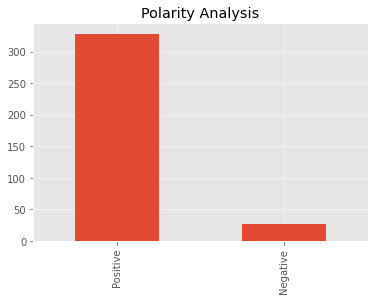

In [ ]:
plt.style.use('ggplot')
mean_sentiment_by_url['polarity type'].value_counts().plot(kind='bar')
plt.title('Polarity Analysis')
plt.show()

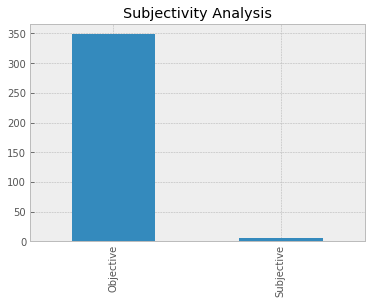

In [ ]:
plt.style.use('bmh')
mean_sentiment_by_url['subjectivity type'].value_counts().plot(kind='bar')
plt.title('Subjectivity Analysis')
plt.show()

##URL Specific Article Content Analysis

Below we will pull all sentiments for a specific url. The example below references url_link_list, a list of all unique urls sorted by crawl_dates count. This list can be applied to pull the sentiments in order of urls with the most changes.

In [ ]:
#gathering all of the sentiment outcomes for the url with the most changes
url_link = url_count_list[0]

sentiment_specific_url = web_page_text[web_page_text['url'] == url_link]
sentiment_specific_url = sentiment_specific_url.sort_values(by=['crawl_date'], ascending=True).reset_index(drop=True)
sentiment_specific_url.sample(1)

crawl_date     domain  \
51 2021-03-26  canada.ca   

                                                                                           url  \
51  https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html   

   mime_type_web_server mime_type_tika language  \
51  text/html            text/html      en        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Text(0.5, 1.0, 'https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html Polarity Analysis')

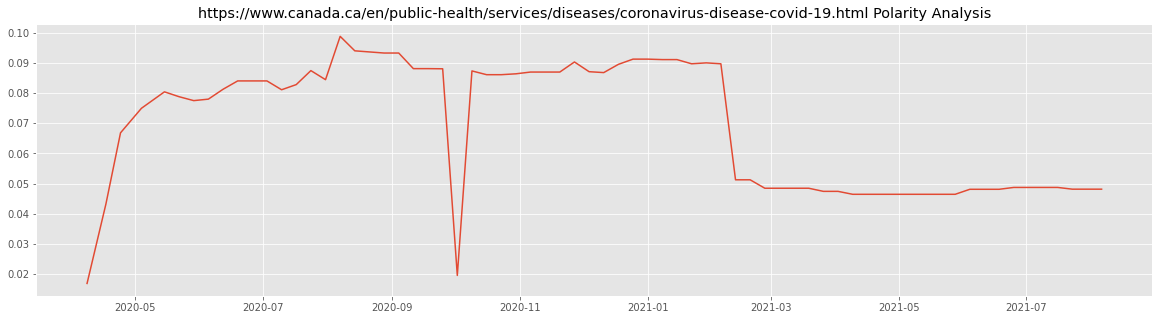

In [ ]:
#note: the polarity and subjectivity are displayed on two separate graphs instead of a double line graph because 
#the polarity can range from -1.0 to 1.0, while subjectivity can only range from 0.0 to 1.0

plt.style.use('ggplot')
plt.figure(figsize = (20, 5))
plt.plot(sentiment_specific_url['crawl_date'], sentiment_specific_url['polarity'])
plt.title(url_link+ ' Polarity Analysis')

Text(0.5, 1.0, 'https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.htmlSubjectivity Analysis')

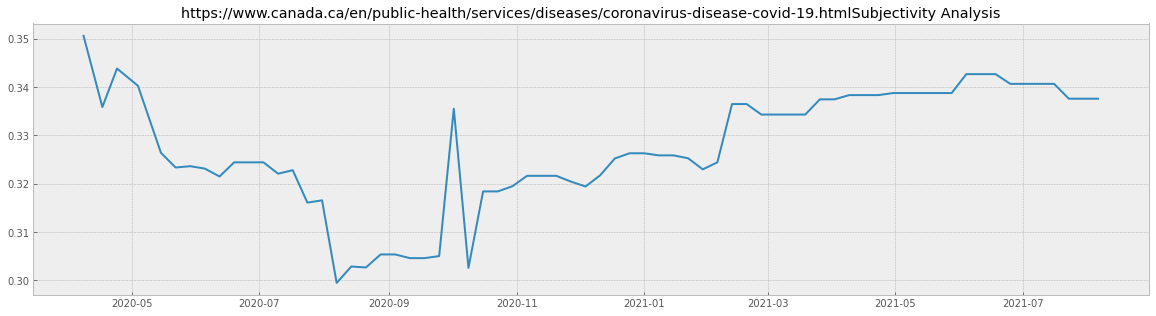

In [ ]:
plt.style.use('bmh')
plt.figure(figsize = (20, 5))
plt.plot(sentiment_specific_url['crawl_date'], sentiment_specific_url['subjectivity'])
plt.title(str(url_link)+ 'Subjectivity Analysis')

##URL Specific Article Changes Calculations (Levenshtein Distance)
Below we calculated the change in polarity and subjectivity from the previous article. We will then compare the articles and return a count of the number of words that were not found in the previous article. 

Applying Levenshtein Distance, we want to find how different the words had changed after the article had been edited. The average distance is then returned.

In [ ]:
#compare the words that were removed in the previous verison, to the words added to the new verison using levenshtein distance. 
#returning the average distance
def levenshteinDistance(words_removed_prev, words_added_new, previous_content, new_content):
  lev_total = 0
  lev_count = 0
  
  for prev_word, new_word in zip(words_removed_prev, words_added_new):
    lev_total = lev_total + lev(prev_word, new_word)
    lev_count = lev_count +1

  if (lev_count>0):
    return lev_total/lev_count
  else:
    return 0

In [ ]:
changes_in_article = sentiment_specific_url

for i in range(1, len(sentiment_specific_url)):
  changes_in_article.loc[i, 'polarity_change'] = changes_in_article.loc[i, 'polarity'] - changes_in_article.loc[i-1, 'polarity']
  changes_in_article.loc[i, 'subjectivity_change'] = changes_in_article.loc[i, 'subjectivity'] - changes_in_article.loc[i-1, 'subjectivity']

  previous_content = changes_in_article.loc[i-1, 'content'].lower().split()
  new_content = changes_in_article.loc[i, 'content'].lower().split()

  prev_content_list = []
  new_content_list = []
  for w in previous_content:
    if w.isalpha():
      prev_content_list.append(w)
  
  for w in new_content:
    if w.isalpha():
      new_content_list.append(w)

  #words that were in the previous verison, and were removed from the new edit
  words_removed_prev = []
  for word in prev_content_list:
    if word not in new_content_list:
      words_removed_prev.append(word)

  #words that were added in the new verison, and were not in the previous edit
  words_added_new = []
  for word in new_content_list:
    if word not in previous_content_list:
      words_added_new.append(word)

  changes_in_article.loc[i, 'missing_words'] = '  '.join(words_removed_prev).join(words_added_new)
  changes_in_article.loc[i, 'levenshtein_distance'] = levenshteinDistance(words_removed_prev, words_added_new, previous_content, new_content)
  changes_in_article.loc[i, 'count_different_words'] = len(words_removed_prev) + len(words_added_new)


#changes_in_article.head(2)
changes_in_article[['crawl_date', 'domain', 'url', 'mime_type_web_server', 'mime_type_tika', 'language', 
                    'polarity_change', 'subjectivity_change', 'count_different_words', 'levenshtein_distance']].head(10)

,crawl_date,domain,url,mime_type_web_server,mime_type_tika,language,polarity_change,subjectivity_change,count_different_words,levenshtein_distance
0,2020-04-08,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,NaN,NaN,NaN,NaN
1,2020-04-17,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,0.026251,-0.014749,286.0,6.450000
2,2020-04-24,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,0.023620,0.007985,279.0,6.400000
3,2020-05-04,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,0.008127,-0.003578,298.0,6.846154
4,2020-05-15,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,0.005447,-0.013883,617.0,7.487805
5,2020-05-22,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,-0.001614,-0.003040,593.0,6.400000
6,2020-05-29,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,-0.001295,0.000267,590.0,0.000000
7,2020-05-29,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,0.000000,0.000000,590.0,0.000000
8,2020-06-05,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,0.000492,-0.000496,595.0,8.000000
9,2020-06-12,canada.ca,https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html,text/html,text/html,en,0.003263,-0.001635,623.0,7.352941


In [ ]:
print(changes_in_article['levenshtein_distance'].mean())

4.595232315180884


##Spearman's Correlation for Levenshtein Distance and Sentiment Changes
*   [-1] a perfect negative relationship between two variables
*   [0]  no relationship between two variables
*   [1]  a perfect positive relationship between two variables

In [ ]:
from scipy import stats
spearman_df = changes_in_article.drop(index=[0])

polarity_change = spearman_df['polarity_change'].to_list()
subjectivity_change = spearman_df['subjectivity_change'].to_list()
levenshtein_calculations = spearman_df['levenshtein_distance'].to_list()

#stats.spearmanr([1,2,3,4,5], [5,6,7,8,7])
polarity_levenshtein = stats.spearmanr(polarity_change, levenshtein_calculations)
subjectivity_levenshtein = stats.spearmanr(subjectivity_change, levenshtein_calculations)

print(polarity_levenshtein)
print(subjectivity_levenshtein)

SpearmanrResult(correlation=0.03972350308161859, pvalue=0.7440495886950336)
SpearmanrResult(correlation=-0.18664701271665968, pvalue=0.12183593671435583)


##Identify any Articles with Varying Sentiments

Using drop_duplicates, we will remove all records with the same url and sentiment, keeping only those with differing crawl_dates, and sentiment types. However, because drop_duplicate will keep all unique rows, we will then need to apply duplicated() to locate all rows with duplicate url fields. The end result will pull in all duplicate urls with different sentiment types.

In [ ]:
polarity_change = pd.DataFrame(web_page_sentiment.drop_duplicates(subset=['domain', 'url', 'polarity type']))
polarity_change = polarity_change[polarity_change.duplicated(subset=['url'], keep=False)]

if (len(polarity_change) > 0):
  plt.style.use('ggplot')
  plt.figure(figsize = (20, 5))
  
  polarity_change_list = polarity_change['url'].unique()

  for i in range(0, len(polarity_change_list)):
    url = polarity_change_list[i]
    sentiment_specific_url = web_page_sentiment[web_page_sentiment['url'] == url]

    plt.plot(sentiment_specific_url['crawl_date'], sentiment_specific_url['polarity'], label=url)
    plt.title('Polarity Analysis of Changed URLS')

print('original web_page_sentiment count:' +str(len(web_page_sentiment)))
print('differing polarity change count:' +str(len(polarity_change)))

In [ ]:
subjectivity_change = pd.DataFrame(web_page_sentiment.drop_duplicates(subset=['domain', 'url', 'subjectivity type']))
subjectivity_change = subjectivity_change[subjectivity_change.duplicated(subset=['url'], keep=False)]

if (len(subjectivity_change) > 0):
  plt.style.use('bmh')
  plt.figure(figsize = (20, 5))
  
  subjectivity_change = subjectivity_change['url'].unique()

  for i in range(0, len(subjectivity_change)):
    url = subjectivity_change[i]
    sentiment_specific_url = web_page_sentiment[web_page_sentiment['url'] == url]

    plt.plot(sentiment_specific_url['crawl_date'], sentiment_specific_url['subjectivity'], label=url)
    plt.title('Subjectivity Analysis of Changed URLS')


print('original web_page_sentiment count:', (len(web_page_sentiment)))
print('differing subjectivity change count:', (len(subjectivity_change)))

##Sentiment: Min, Max and Difference
Calculates the min, max and difference sentiment for each url


In [ ]:
#sample1 = pd.DataFrame(sample.groupby('url').agg({'polarity': ['mean', 'min', 'max']}))
polarity_difference = pd.DataFrame(web_page_sentiment.groupby('url').agg({'polarity': np.ptp}))
polarity_difference = polarity_difference.sort_values(by=['url'], ascending=True)
polarity_difference
#polarity_difference = polarity_difference[polarity_difference['polarity'] > 0]

#sample['difference'] = sample['max'] - sample['min']